<a href="https://colab.research.google.com/github/chw8207/fastai_pytorch/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_fastai_%EA%B0%9C%EC%9A%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import tensorflow as tf
from fastai.vision.all import *
from fastai.text.all import *
from fastai.tabular.all import *
from fastai.collab import *
import numpy as np

### GPU 설정

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0' :
    raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [4]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1555555450943814057
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15208677376
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14898682650821539285
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
xla_global_id: 416903419
]


### 이미지 인식 모델

In [ ]:
path = untar_data(URLs.PETS)/'images'

In [ ]:
# 데이터셋에 포함된 파일명 규칙에 따라
# 고양이 레이블을 지정하는 함수(고양이(대문자) : True)
def is_cat(x) :
  return x[0].isupper()

In [ ]:
# fastai에 데이터셋의 종류와 구조화 방법 알려주기
# from_name_func : 파일명에 적용할 함수로 레이블 추출
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2,
    seed=42, label_func=is_cat, item_tfms=Resize(224)
)

In [ ]:
# 합성곱 신경상 생성
learn = cnn_learner(dls, resnet34, metrics=error_rate)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593

In [ ]:
# 모델 적합
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.171382,0.014924,0.004736,00:34


epoch,train_loss,valid_loss,error_rate,time
0,0.055493,0.011533,0.004736,00:28


In [ ]:
# fastai로 세그멘테이션 모델 학습
path = untar_data(URLs.CAMVID_TINY)

In [ ]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames=get_image_files(path/'images'),
    label_func=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes=np.loadtxt(path/'codes.txt', dtype=str)
)

In [ ]:
learn = unet_learner(dls, resnet34)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
learn.fine_tune(8)

epoch,train_loss,valid_loss,time
0,2.790550,2.396584,00:01


epoch,train_loss,valid_loss,time
0,1.706313,1.566071,00:01
1,1.486117,1.651897,00:01
2,1.405485,1.207893,00:01
3,1.288826,1.024291,00:01
4,1.173403,1.017355,00:01
5,1.069094,0.907799,00:01
6,0.980853,0.867993,00:01
7,0.910506,0.859087,00:01


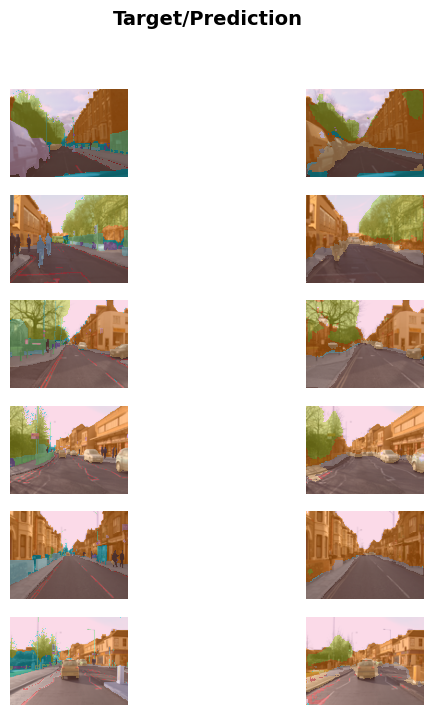

In [ ]:
# 모델 시각화
learn.show_results(max_n=6, figsize=(7,8))

### 자연어(NLP)처리 분야

In [ ]:
dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.470024,0.392341,0.821000,01:19


epoch,train_loss,valid_loss,accuracy,time
0,0.306301,0.251194,0.900160,02:22
1,0.251460,0.204458,0.918360,02:22
2,0.189992,0.193831,0.925160,02:21
3,0.135901,0.190921,0.930320,02:22


In [ ]:
# 짧은 단어로 간단한 시험
learn.predict('I really liked that movie!')

('pos', tensor(1), tensor([2.2311e-04, 9.9978e-01]))

In [ ]:
learn.predict('픽사 인생영화 됐어요ㅠㅠㅠㅠ')

('pos', tensor(1), tensor([0.2474, 0.7526]))

### fastai 메서드 확인하기

In [ ]:
doc(learn.predict)

Learner.predict(item, rm_type_tfms=None, with_input=False)
Prediction on `item`, fully decoded, loss function decoded and probabilities

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


### 테이블형 모델 다루기

In [5]:
path = untar_data(URLs.ADULT_SAMPLE)

In [7]:
dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names='salary',
                                  cat_names=['workclass', 'education',
                                             'marital-status', 'occupation',
                                             'relationship', 'race'],
                                  cont_names=['age', 'fnlwgt', 'education-num'],
                                  procs=[Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)

In [8]:
# 모델 학습
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.374961,0.384499,0.818950,00:07
1,0.369007,0.351467,0.837838,00:04
2,0.358631,0.347746,0.840448,00:04


### 추천 시스템

In [10]:
path = untar_data(URLs.ML_SAMPLE)

In [11]:
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5, 5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.497972,1.440329,00:00


epoch,train_loss,valid_loss,time
0,1.377463,1.382715,00:00
1,1.277825,1.206567,00:00
2,1.037674,0.893450,00:00
3,0.802188,0.736618,00:00
4,0.686428,0.695910,00:00
5,0.646958,0.683931,00:00
6,0.627172,0.677714,00:00
7,0.622325,0.675349,00:00
8,0.611854,0.674142,00:00
9,0.604296,0.674094,00:00


In [13]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,14.0,3.0,4.0,3.666723
1,86.0,3.0,4.5,3.696949
2,32.0,63.0,5.0,4.930476
3,60.0,21.0,2.0,4.068352
4,18.0,26.0,4.0,3.606600
5,64.0,69.0,3.5,4.290851
6,89.0,89.0,3.0,3.896270
7,98.0,65.0,4.0,4.228735
8,36.0,50.0,4.0,4.055977
